In [25]:
# Temporal Fusion Transformer (TFT) for Cherry Blossom Bloom Day
#
# This notebook fits a Temporal Fusion Transformer (TFT) using the `pytorch-forecasting` library.
# It mirrors the other modeling notebooks (OLS, SARIMA, LightGBM, LSTM): same data splits,
# evaluation metrics (RMSE, MAE, WMAPE), and plotting style.


In [26]:
# Notes before running
#
# - This notebook requires heavy dependencies: pytorch, pytorch-lightning, and pytorch-forecasting.
# - Install with (example):
#
#   pip install torch pytorch-lightning pytorch-forecasting
#
# - If you have GPU available, PyTorch will use it; otherwise it will run on CPU (slower).


In [27]:
# Plan / checklist
#
# - Load the cherry blossom dataset and prepare features.
# - Create sequential train/validation pool (1921-2015) and test set (2016-2025). Within 1921-2015,
#   use an 80/20 time-ordered split for train/validation.
# - Build a TimeSeriesDataSet appropriate for TFT (single series grouped by an ID).
# - Train a TFT model using PyTorch Lightning trainer with early stopping and checkpointing.
# - Produce one-step-ahead forecasts for each year in 2016-2025 using a sliding-window prediction method
#   (so forecasts are directly comparable to observed bloom_day values in the CSV).
# - Compute RMSE, MAE, and WMAPE on the test set and plot actuals vs forecasts (blue actual, red forecast)
#   with a dashed vertical line at 2016.


In [28]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set_theme(style='whitegrid')

# Try to import pytorch-forecasting and pytorch-lightning components safely
HAS_PF = True
try:
    pf = importlib.import_module('pytorch_forecasting')
    TimeSeriesDataSet = getattr(pf, 'TimeSeriesDataSet')
    # load TemporalFusionTransformer from the models submodule to ensure correct class
    tft_mod = importlib.import_module('pytorch_forecasting.models.temporal_fusion_transformer')
    TemporalFusionTransformer = getattr(tft_mod, 'TemporalFusionTransformer')
    Baseline = getattr(pf, 'Baseline')
    # metrics and data submodules
    pf_metrics = importlib.import_module('pytorch_forecasting.metrics')
    QuantileLoss = getattr(pf_metrics, 'QuantileLoss')
    pf_data = importlib.import_module('pytorch_forecasting.data')
    GroupNormalizer = getattr(pf_data, 'GroupNormalizer')
except Exception as e:
    HAS_PF = False
    TimeSeriesDataSet = None
    TemporalFusionTransformer = None
    Baseline = None
    QuantileLoss = None
    GroupNormalizer = None

try:
    # prefer the 'lightning.pytorch' namespace which pytorch-forecasting uses internally
    try:
        pl = importlib.import_module('lightning.pytorch')
    except Exception:
        pl = importlib.import_module('pytorch_lightning')
    EarlyStopping = getattr(importlib.import_module(pl.__name__ + '.callbacks'), 'EarlyStopping')
    ModelCheckpoint = getattr(importlib.import_module(pl.__name__ + '.callbacks'), 'ModelCheckpoint')
except Exception:
    # allow notebook to open; will raise a clear error when user tries to run the training cells
    pl = None
    EarlyStopping = None
    ModelCheckpoint = None

from sklearn.metrics import mean_squared_error, mean_absolute_error


## 1) Load data

In [29]:
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))
df.head()


Loaded rows: 105


,year,days_dec_ge_45,days_jan_ge_45,days_feb_ge_45,prec_winter,mean_temp_winter,surface_temp_chg,climate_incidents,bloom_day
0,1921,30,24,23,3.41,42.8,-0.05,3,79
1,1922,20,17,19,2.56,39.1,-0.12,2,97
2,1923,18,15,14,3.12,36.4,-0.18,1,99
3,1924,25,22,25,3.68,43.2,-0.09,4,104
4,1925,16,12,14,2.89,36.8,-0.14,2,86


## 2) Prepare features and target

In [30]:
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# create time_idx (required by pytorch-forecasting)
df = df.sort_values('year').reset_index(drop=True)
df['time_idx'] = (df['year'] - df['year'].min()).astype(int)
# single group id for the single time series
df['series'] = 'cherry_blossom'

# drop rows with missing essential values
df = df.dropna(subset=['time_idx','bloom_day'] + numeric_cols).reset_index(drop=True)

FEATURES = numeric_cols
TARGET = 'bloom_day'


## 3) Create train/validation/test splits (sequential)

In [31]:
train_val_df = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('time_idx').reset_index(drop=True)

# test pool
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('time_idx').reset_index(drop=True)

print(f'Train/Val rows: {len(train_val_df)}, Test rows: {len(test_df)}')

n = len(train_val_df)
if n == 0:
    raise ValueError('No data available in 1921-2015 range to train/validate on.')

train_n = int(np.floor(n * 0.8))
train_df = train_val_df.iloc[:train_n].reset_index(drop=True)
val_df = train_val_df.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}')


Train/Val rows: 95, Test rows: 10
Train rows: 76, Val rows: 19


## 4) Build TimeSeriesDataSet for TFT

In [32]:
# Ensure pytorch-forecasting is available before constructing the dataset
if not HAS_PF or GroupNormalizer is None:
    raise ImportError(
        "pytorch-forecasting is required to build TimeSeriesDataSet.\n"
        "Install with: pip install pytorch-forecasting"
    )

# settings
max_encoder_length = min(30, len(train_df))  # how many historical steps the model sees
max_prediction_length = 1  # we'll predict one step ahead and slide over test years

# allow variable (shorter) encoder lengths so validation sequences aren't filtered out
training = TimeSeriesDataSet(
    train_df,
    time_idx='time_idx',
    target=TARGET,
    group_ids=['series'],
    min_encoder_length=1,  # allow shorter encoders
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['time_idx'] + FEATURES,
    time_varying_unknown_reals=[TARGET],
    target_normalizer=GroupNormalizer(groups=['series']),
)

# create validation dataset from the same settings but ensure max_encoder_length <= len(val_df)
val_max_enc = min(max_encoder_length, len(val_df))
validation = TimeSeriesDataSet.from_dataset(training, val_df, stop_randomization=True, max_encoder_length=val_max_enc, min_encoder_length=1)

# dataloaders
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


## 5) Configure and train Temporal Fusion Transformer

In [33]:
if not HAS_PF or pl is None:
    raise ImportError("pytorch-forecasting and pytorch-lightning are required to run this cell.\nInstall with: pip install torch pytorch-lightning pytorch-forecasting")

pl.seed_everything(42)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, mode="min")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback, checkpoint_callback],
    accelerator='auto',
    devices='auto',
    logger=False,
    enable_progress_bar=True,
)

# build model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # for quantiles
    loss=QuantileLoss(),
)

print('Model built. Start training...')

# Wrap the TFT object in a LightningModule adapter to ensure compatibility with Trainer
class TFTLightningWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def training_step(self, batch, batch_idx):
        # delegate to underlying model; be defensive about return types
        out = None
        if hasattr(self.tft_model, 'training_step'):
            out = self.tft_model.training_step(batch, batch_idx)
        # out can be: Tensor, dict with 'loss' or other keys, or Lightning-specific object
        if isinstance(out, dict):
            # if there's a loss key, return it as the loss tensor and log other metrics
            if 'loss' in out:
                loss = out['loss']
                # log remaining numeric entries
                to_log = {k: v for k, v in out.items() if k != 'loss' and isinstance(v, (int, float, torch.Tensor))}
                if to_log:
                    self.log_dict(to_log, on_step=False, on_epoch=True, prog_bar=False, logger=True)
                return loss
            # if dict has numeric tensor values but no explicit 'loss', try to pick first tensor
            for v in out.values():
                if isinstance(v, torch.Tensor):
                    return v
            # otherwise fallback to zero loss to avoid breaking Trainer
            return torch.tensor(0.0, device=self.device, requires_grad=True)
        if isinstance(out, torch.Tensor):
            return out
        # If underlying returned a Lightning-specific object or None, try calling its loss attribute
        try:
            if hasattr(out, 'loss'):
                return out.loss
        except Exception:
            pass
        # final fallback: zero tensor (should rarely happen)
        return torch.tensor(0.0, device=self.device, requires_grad=True)

    def validation_step(self, batch, batch_idx):
        out = None
        if hasattr(self.tft_model, 'validation_step'):
            out = self.tft_model.validation_step(batch, batch_idx)
        if isinstance(out, dict):
            # log numeric entries
            to_log = {k: v for k, v in out.items() if isinstance(v, (int, float, torch.Tensor))}
            if to_log:
                self.log_dict(to_log, on_step=False, on_epoch=True, prog_bar=False, logger=True)
            return out
        return out

    def configure_optimizers(self):
        if hasattr(self.tft_model, 'configure_optimizers'):
            return self.tft_model.configure_optimizers()
        return super().configure_optimizers()

    def training_epoch_end(self, outputs):
        if hasattr(self.tft_model, 'training_epoch_end'):
            return self.tft_model.training_epoch_end(outputs)

    def validation_epoch_end(self, outputs):
        if hasattr(self.tft_model, 'validation_epoch_end'):
            return self.tft_model.validation_epoch_end(outputs)

    def forward(self, *args, **kwargs):
        # delegate forward
        return self.tft_model(*args, **kwargs)

# Use the wrapped model only when necessary (handle version differences)
try:
    is_lightning_module = pl is not None and isinstance(tft, pl.LightningModule)
except Exception:
    is_lightning_module = False

if is_lightning_module:
    trainer.fit(tft, train_dataloader, val_dataloader)
    best_model_path = checkpoint_callback.best_model_path
    # if checkpoint created, load to ensure consistent API for later prediction
    if best_model_path:
        tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
else:
    tft_wrapper = TFTLightningWrapper(tft)
    trainer.fit(tft_wrapper, train_dataloader, val_dataloader)
    best_model_path = checkpoint_callback.best_model_path
    if best_model_path:
        tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Model built. Start training...



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 528    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.9 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.1 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Optional: Optuna hyperparameter tuning (quick search)
Set run_optuna = True to run the search (it can be slow). The cell runs a short tuning strategy and saves best params to `notebooks/tft_optuna_best_params.json`.

In [34]:
run_optuna = True  # change to True to run Optuna tuning

if run_optuna:
    import optuna, json

    def _get_device_count():
        # prefer CUDA, then MPS, else CPU
        try:
            if torch.cuda.is_available():
                return 1
            import torch.backends.mps as _mps
            if hasattr(_mps, 'is_available') and _mps.is_available():
                return 1
        except Exception:
            pass
        return None

    def objective(trial):
        # sample a compact set of sensible hyperparameters
        lr = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
        hidden_size = trial.suggest_int('hidden_size', 8, 64)
        attention_head_size = trial.suggest_int('attention_head_size', 1, 4)
        dropout = trial.suggest_float('dropout', 0.0, 0.3)
        hidden_continuous_size = trial.suggest_int('hidden_continuous_size', 8, 32)

        # build a small TFT with sampled params (kept small for quick trials)
        try:
            model = TemporalFusionTransformer.from_dataset(
                training,
                learning_rate=lr,
                hidden_size=hidden_size,
                attention_head_size=attention_head_size,
                dropout=dropout,
                hidden_continuous_size=hidden_continuous_size,
                output_size=7,
                loss=QuantileLoss(),
            )
        except Exception as e:
            print('from_dataset failed in trial:', e)
            return float('inf')

        # quick trainer to evaluate the candidate
        trainer_kwargs = dict(
            max_epochs=8,
            limit_train_batches=0.5,  # only a fraction of the data for speed
            limit_val_batches=0.5,
            logger=False,
            enable_progress_bar=False,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, mode='min')],
        )
        devices = _get_device_count()
        trainer_kwargs['accelerator'] = 'auto'
        trainer_kwargs['devices'] = devices

        try:
            trainer_opt = pl.Trainer(**trainer_kwargs)
            trainer_opt.fit(model, train_dataloader, val_dataloader)
            # get val_loss from callback metrics
            val_loss = trainer_opt.callback_metrics.get('val_loss')
            if val_loss is None:
                # fallback to any metric
                for k, v in trainer_opt.callback_metrics.items():
                    if 'val' in k:
                        val_loss = v
                        break
            if val_loss is None:
                return float('inf')
            if hasattr(val_loss, 'detach'):
                return float(val_loss.detach().cpu().numpy())
            return float(val_loss)
        except Exception as e:
            print('Trainer failure during trial:', e)
            return float('inf')

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, n_jobs=-1)
    print('Optuna best params:', study.best_params)
    best_params = study.best_params
    # save on disk inside notebooks folder
    import os
    out_dir = 'notebooks'
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'tft_optuna_best_params.json')
    with open(out_path, 'w') as f:
        json.dump(best_params, f)
    print('Saved best params to', out_path)


[I 2025-11-23 20:30:17,215] A new study created in memory with name: no-name-edf24565-a82f-49e6-8915-bf1f9a01b3c9
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
💡 Tip: For seamless cloud uploads and versioning, try installing [

Optuna best params: {'learning_rate': 0.00027595463974053905, 'hidden_size': 29, 'attention_head_size': 3, 'dropout': 0.08814530105094036, 'hidden_continuous_size': 10}
Saved best params to notebooks/tft_optuna_best_params.json


## 6) One-step-ahead forecasting for years 2016-2025 (sliding window)

We'll produce one-step-ahead forecasts for each year in the test set using the previous `max_encoder_length` years as encoder input. This requires building a small prediction dataframe for each forecast date that contains the encoder window plus the prediction row (with NaN target).


Note: we assume the exogenous features for test years are present in `df` (they are in the provided CSV), so the model can use them as known_reals when predicting.

In [35]:
preds = []
for idx, row in test_df.iterrows():
    year = int(row['year'])
    time_idx = int(row['time_idx'])
    # encoder window ends at time_idx - 1
    encoder_end = time_idx - 1
    encoder_start = max(0, encoder_end - max_encoder_length + 1)
    encoder_df = df[(df['time_idx'] >= encoder_start) & (df['time_idx'] <= encoder_end)].copy()
    # create one-row dataframe for the prediction time with bloom_day NaN
    pred_row = row.copy()
    # pytorch-forecasting requires finite target values when constructing a predict dataset in some versions.
    # Fill with a numeric sentinel (0.0) for the prediction row; the model will be run in predict mode so this
    # value won't affect training.
    pred_row[TARGET] = 0.0
    # concatenate encoder + prediction row
    model_input = pd.concat([encoder_df, pd.DataFrame([pred_row])], ignore_index=True)
    # safety: replace any remaining NaNs in the target column
    model_input[TARGET] = model_input[TARGET].fillna(0.0)
    # ensure series and time_idx exist
    model_input['series'] = 'cherry_blossom'

    # create dataset for prediction from the training settings
    predict_dataset = TimeSeriesDataSet.from_dataset(training, model_input, predict=True, stop_randomization=True)
    predict_dataloader = predict_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

    # predict
    out = tft.predict(predict_dataloader)
    # tft.predict may return numpy arrays, pandas-like objects, or torch Tensors depending on library versions.
    try:
        if isinstance(out, np.ndarray):
            point_pred = float(out.flatten()[0])
        elif hasattr(out, 'iloc'):
            # pandas Series/DataFrame
            point_pred = float(out.iloc[0])
        elif torch.is_tensor(out):
            point_pred = float(out.detach().cpu().numpy().flatten()[0])
        else:
            # fallback: coerce to numpy and take the first element
            point_pred = float(np.array(out).flatten()[0])
    except Exception:
        # as a last resort try converting the first element safely
        try:
            point_pred = float(np.array(out)[0])
        except Exception:
            raise

    preds.append(point_pred)

# attach preds to test_df
if len(preds) > 0:
    test_df = test_df.copy()
    test_df['pred_bloom_day'] = preds


## 7) Evaluate on test set (2016-2025)

In [36]:
if len(test_df) == 0:
    print('No test data available for 2016-2025 range.')
else:
    y_test = test_df[TARGET].values
    y_pred = test_df['pred_bloom_day'].values
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    test_wmape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))



Test set performance (2016-2025)
Rows: 10
RMSE: 10.148
MAE: 9.007
WMAPE: 10.622%


## 8) Plot actuals (since 1921) and forecasts (2016-2025)

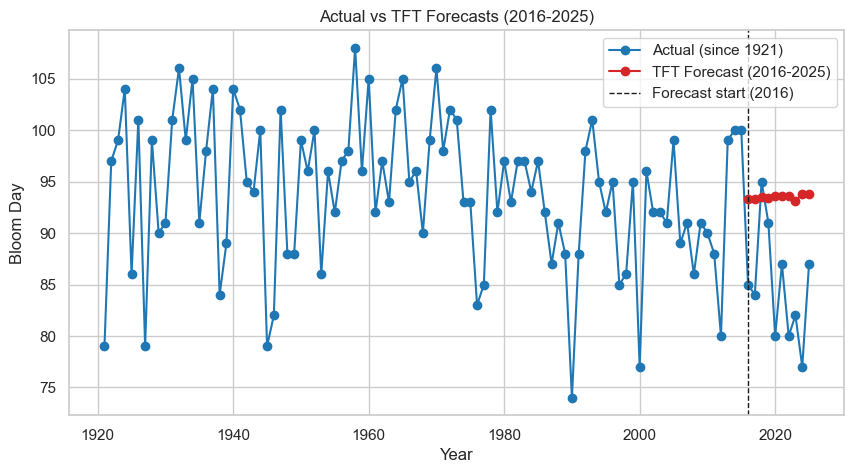

In [37]:
full_years = df['year']
full_actuals = df[TARGET]

plt.figure(figsize=(10, 5))
plt.plot(full_years, full_actuals.values, marker='o', color='tab:blue', label='Actual (since 1921)')
if len(test_df) > 0:
    plt.plot(test_df['year'], test_df['pred_bloom_day'].values, marker='o', color='tab:red', label='TFT Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs TFT Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()
